In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats
import scipy.optimize as opt

In [4]:
import freqepid

# 1. load data

In [5]:
GPi = np.load('data/GPi.npz')

In [6]:
data = pd.read_feather('data/CovidCastStateAdj_2.feather').iloc[:,:-1]

## comparison with unadjusted data

In [7]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates

In [8]:
data_raw = pd.read_feather('data/CovidCastState.feather').iloc[:,:-1]

In [9]:
regions = ['ca', 'tx', 'fl', 'ny']

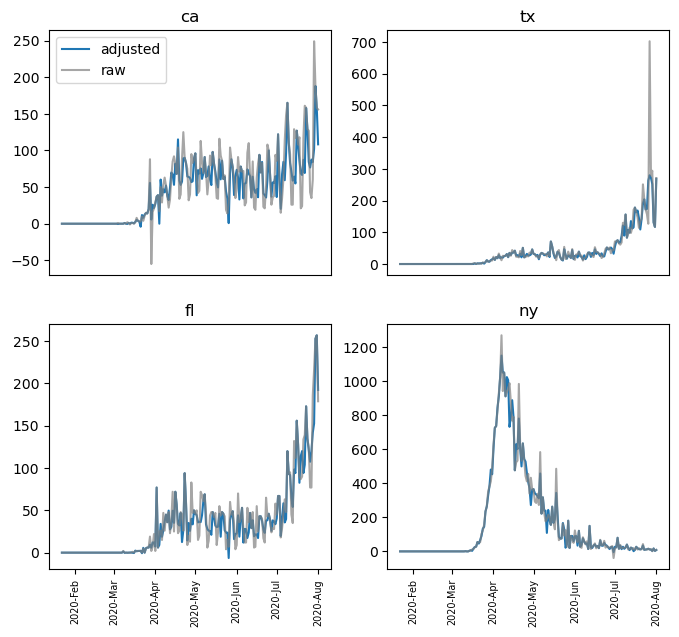

In [10]:
plt.figure(figsize=(8,7))

for i, r in enumerate(regions):
    plt.subplot(2,2,i+1)
    
    data_i = data[data.geo_value == r]
    data_i_raw = data_raw[data_raw.geo_value == r]
    
    plt.plot(data_i.time_value, data_i.deaths, label='adjusted')
    plt.plot(data_i_raw.time_value, data_i_raw.deaths, color='grey', alpha=0.7, label='raw')
    plt.title(r)
    
    if i < 2:
        plt.xticks([],[])
    
    if i >= 2:
        dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
        plt.gca().xaxis.set_major_formatter(dtFmt) 
        # show every 12th tick on x axes
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        plt.xticks(rotation=90, fontweight='light',  fontsize='x-small',)
    
    if i == 0:
        plt.legend()

## truncation

In [11]:
data = data.groupby("geo_value").filter(lambda x: x.deaths.max() > 20)

In [12]:
deaths_raw = data.groupby("geo_value").apply(lambda x: sum(x.deaths))

In [13]:
data = data.groupby("geo_value", group_keys=False).apply(lambda x: 
     x[x.time_value > x[x.deaths.cumsum() > 10].time_value.min() - pd.Timedelta(30, unit='D')])

In [14]:
deaths_trunc = data.groupby("geo_value").apply(lambda x: sum(x.deaths))

In [15]:
deaths_raw - deaths_trunc

geo_value
al    0.0
az    0.0
ca    0.0
co    0.0
ct    0.0
fl    0.0
ga    0.0
il    0.0
in    0.0
la    0.0
ma    0.0
md    0.0
mi    0.0
mn    0.0
mo    0.0
ms    0.0
nc    0.0
ne    0.0
nh    0.0
nj    0.0
nv    0.0
ny    0.0
oh    0.0
pa    0.0
ri    0.0
sc    0.0
tn    0.0
tx    0.0
va    0.0
wa    0.0
dtype: float64

In [16]:
regions = np.array(data['geo_value'].unique())

In [17]:
regions, len(regions)

(array(['al', 'az', 'ca', 'co', 'ct', 'fl', 'ga', 'il', 'in', 'la', 'ma',
        'md', 'mi', 'mn', 'mo', 'ms', 'nc', 'ne', 'nh', 'nj', 'nv', 'ny',
        'oh', 'pa', 'ri', 'sc', 'tn', 'tx', 'va', 'wa'], dtype=object),
 30)

In [18]:
ivs = [5]

In [19]:
np.array(data.columns)[ivs]

array(['full_time_work_prop'], dtype=object)

In [20]:
num_region = len(regions)
d = len(ivs)+1

# 2. EDA

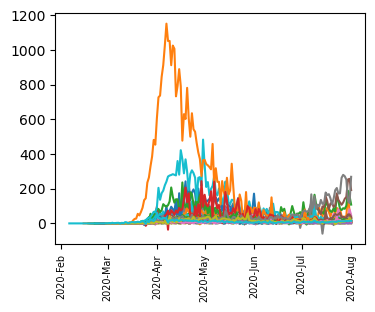

In [21]:
plt.figure(figsize=(4,3))

for r in regions:
    plt.plot(np.array(data[data.geo_value == r].time_value),
             np.array(data[data.geo_value == r].deaths), label=r)
# plt.legend()

dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small',)

plt.show()

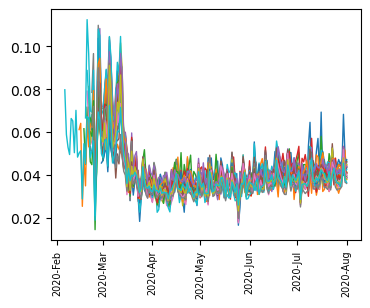

In [22]:
plt.figure(figsize=(4,3))
for i, iv in enumerate(ivs):
    # plt.subplot(2,2,i+1)
    # plt.title(np.array(data.columns)[iv]); # plt.xlabel('days')
    for r in regions:
        plt.plot(np.array(data[data.geo_value == r].time_value),
                 np.array(data[data.geo_value == r].iloc[:,iv]),
                 linewidth=1)

dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small',)        

plt.show()

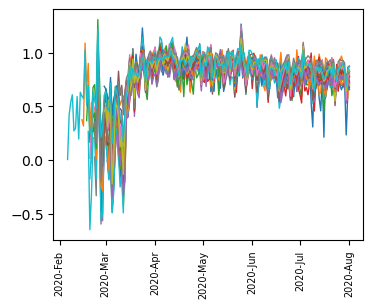

In [23]:
plt.figure(figsize=(4,3))
for i, iv in enumerate(ivs):
    # plt.subplot(2,2,i+1)
    # plt.title(np.array(data.columns)[iv]); # plt.xlabel('days')
    for r in regions:
        plt.plot(np.array(data[data.geo_value == r].time_value),
                 np.array(data[data.geo_value == r].iloc[:,iv]) * (-20) + 1.6,
                 linewidth=1)

dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small',)        

plt.show()

# 3. fit

In [24]:
model = freqepid.Model(GPi['g'], GPi['pi'], T0=40, family='nbinom')

In [25]:
ns_mle = np.zeros(num_region)
ms_mle = np.zeros(num_region)
bs_mle = np.zeros((num_region,d))
covs_mle = np.zeros((num_region,d+2,d+2))

In [27]:
for i_region, r \
in enumerate(regions):
    start_region = time.time()
    sys.__stdout__.write("Program at %s started \n"%r)
    sys.__stdout__.flush()  
    
    # data
    Y = np.array(data[data.geo_value == r].deaths)
    T = Y.shape[0]
    
    A = np.zeros([T, d])
    A[:,0] = np.full(T, 1)
    A[:,1:] = np.array(data[data.geo_value == r].iloc[:,ivs])*(-20) + 1.6
    
    
    # fit
    nmle, mmle, bmle, ll =\
    model.fit(A, Y, n_iter=1000, step_size=1,
              history=False, verbose=False)
    
    ns_mle[i_region] = nmle
    ms_mle[i_region] = mmle
    bs_mle[i_region,:] = bmle
    
    Ihat_dth, Ihat_hac, Ihat_sdw =\
    model.inference(A, Y, nmle, mmle, bmle)
    
    covs_mle[i_region] = la.pinv(Ihat_sdw)

    sys.__stdout__.write("Inference at %s finished, lapse: %f sec. \n"
                     %(r, time.time() - start_region))
    sys.__stdout__.flush() 

Program at al started 


/Users/blueconet/mambaforge/envs/freqepid/lib/python3.10/site-packages/freqepid/model.py:141: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  bhaty = np.linalg.lstsq(Xy, Yy)[0]


Inference at al finished, lapse: 42.547472 sec. 
Program at az started 
Inference at az finished, lapse: 47.068882 sec. 
Program at ca started 


KeyboardInterrupt: 

In [ ]:
# np.savez('result_delphi_ML.npz',
#          ns_mle = ns_mle, ms_mle = ms_mle, 
#          bs_mle = bs_mle, covs_mle = covs_mle)

## plots

In [26]:
locals().update(np.load('result_delphi_ML.npz'))

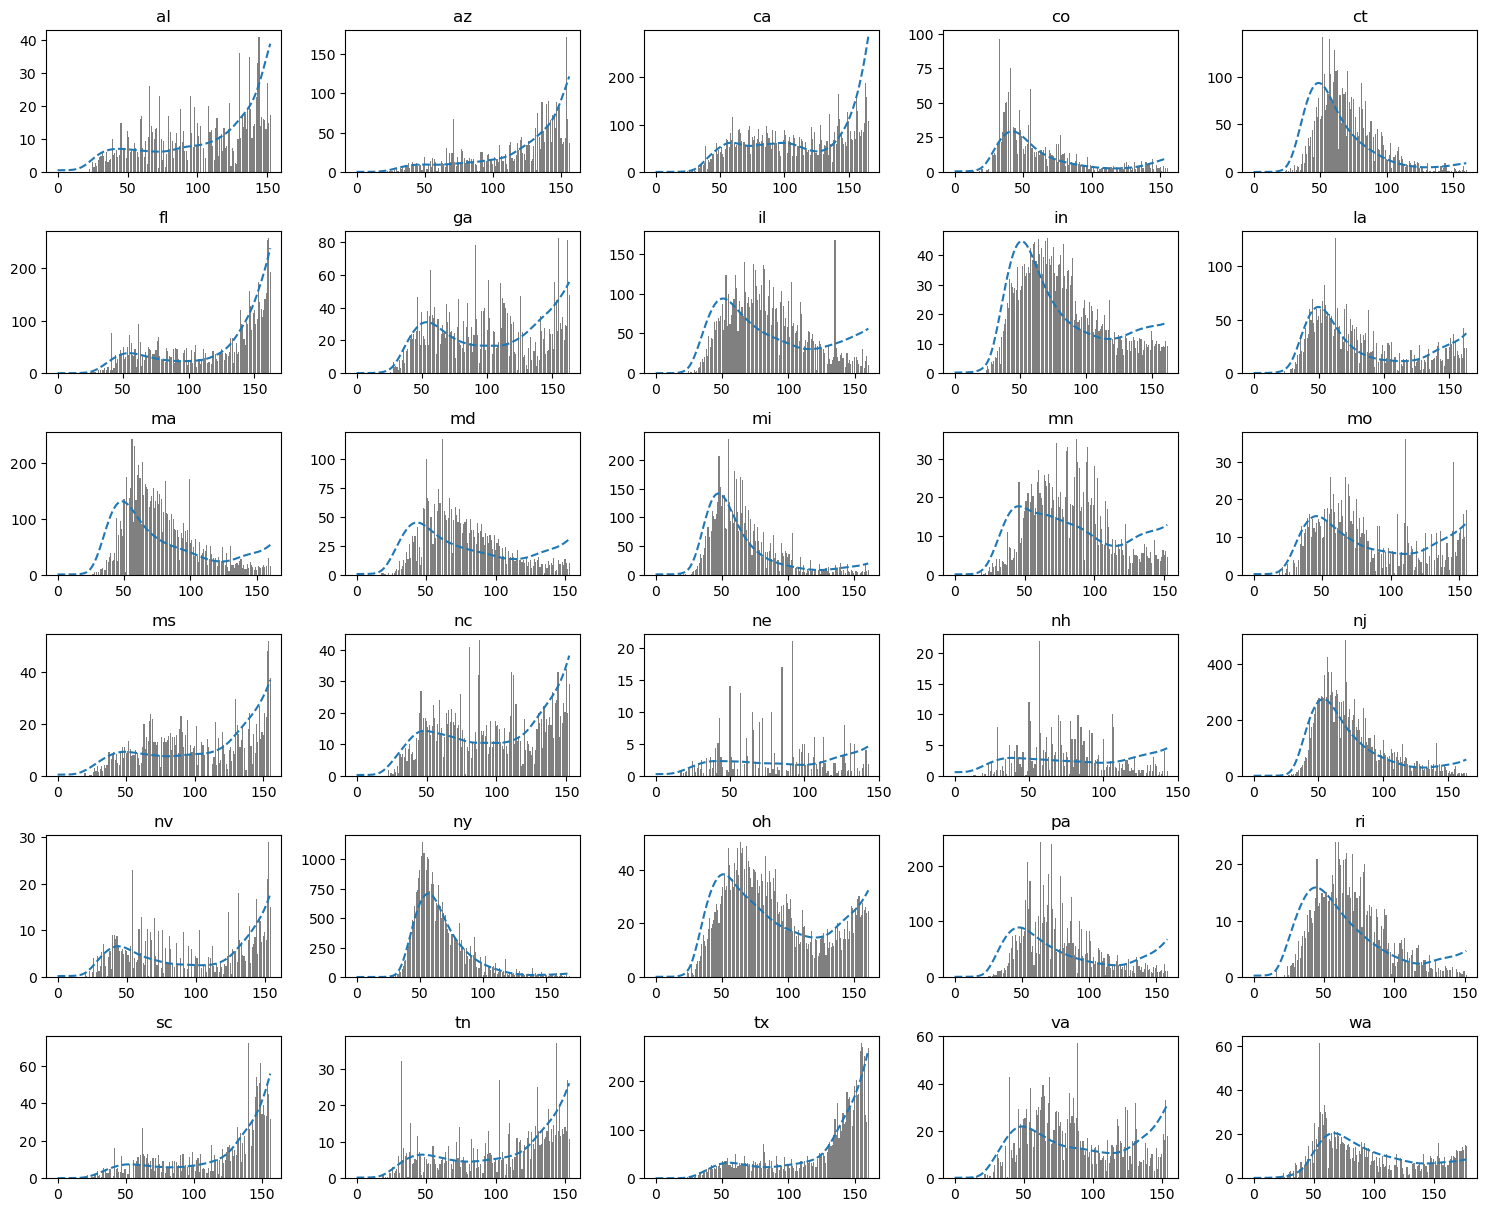

In [27]:
plt.figure(figsize=(15, int(len(regions)/5+1)*2))

for i, r in enumerate(regions):
    plt.subplot(int(len(regions)/5+1),5,i+1)
    
    Y = np.array(data[data.geo_value == r].deaths)
    T = Y.shape[0]
    
    A = np.zeros([T, d])
    A[:,0] = np.full(T, 1)
    A[:,1:] = np.array(data[data.geo_value == r].iloc[:,ivs]) * (-20) + 1.6

    plt.bar(np.arange(T), Y, color='grey')
    plt.plot(model.predict_EY(A, ms_mle[i], bs_mle[i]), linestyle='dashed')
    plt.title('%s'%r)
    plt.ylim(bottom=0)
    
plt.tight_layout()

In [27]:
Vs_mle = covs_mle

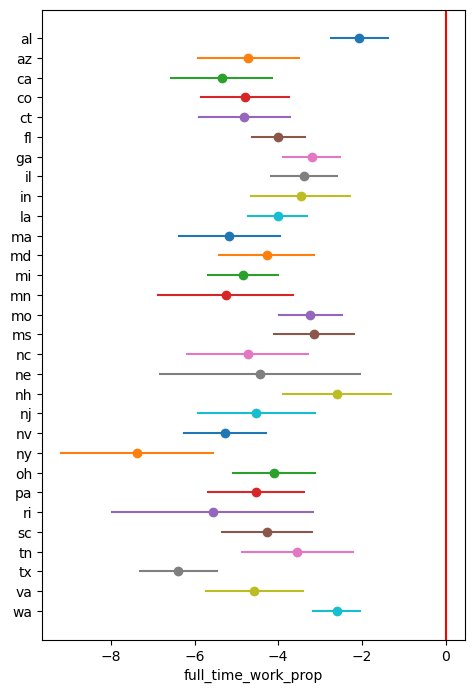

In [28]:
plt.figure(figsize=(12,18))
for k, iv in enumerate(ivs):
    plt.subplot(2,2,k+1)
    plt.gca().invert_yaxis()
    for i, r in enumerate(regions):
        se2 = np.diag(Vs_mle[i])[k+3]
        if se2 > 0:
            plt.plot([bs_mle[i,k+1]-2*np.sqrt(se2), 
                      bs_mle[i,k+1]+2*np.sqrt(se2)],
                     [i, i], color='C%d'%i)
        else:
            plt.axhline(y=i, color='C%d'%i)
        plt.scatter(bs_mle[i,k+1], i, color='C%d'%i)

    plt.axvline(x=0, color='red')
    plt.yticks(np.arange(len(regions)), regions) 
    plt.xlabel(np.array(data.columns)[iv])
plt.show()

(-10.0, 0.0)

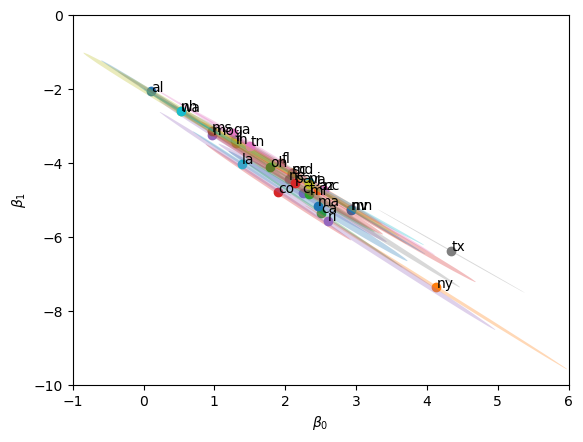

In [29]:
for i_region, (r, bmle, Vmle) \
in enumerate(zip(regions, bs_mle, Vs_mle)):
    p = plt.scatter(*bmle, label="%d"%i_region)
    plt.annotate(r, bmle)
    freqepid.confidence_ellipse(
        bmle, Vmle[2:,2:], n_std=np.sqrt(stats.chi2(2).ppf(0.95)),
        facecolor=p.get_facecolor(), alpha=0.3)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); # plt.legend()
plt.xlim(-1, 6); plt.ylim(-10, 0)

# 3. EBCR

In [30]:
ths_mle = np.concatenate([ms_mle[:,None], bs_mle], -1)
Vs_mle = Vs_mle[:,1:,1:]

In [31]:
result_ebcr = freqepid.EBCR(ths_mle, Vs_mle, num_mc=1000)

In [32]:
result_ebcr.th_o

array([ 2.72247855,  2.12199699, -4.39140191])

In [33]:
result_ebcr.Phi2

array([[ 0.52932335, -0.52203258,  0.45693495],
       [-0.52203258,  1.1686858 , -1.19897176],
       [ 0.45693495, -1.19897176,  1.31295338]])

In [34]:
ths_eb = result_ebcr.ths_eb

In [35]:
Vs_eb = result_ebcr.covs_eb

In [36]:
chi_pa = result_ebcr.chi_pa(0.05)

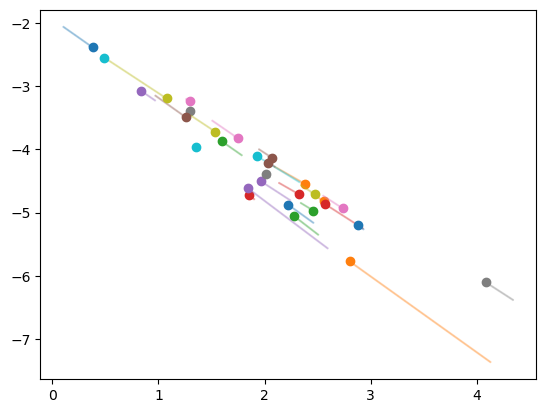

In [37]:
for i in np.arange(num_region):
    p = plt.scatter(*ths_eb[i,1:])
    plt.arrow(*ths_mle[i,1:], *(ths_eb[i,1:]-ths_mle[i,1:]), width=0.01, 
             length_includes_head=True,
             color=p.get_facecolor(), alpha=0.3)

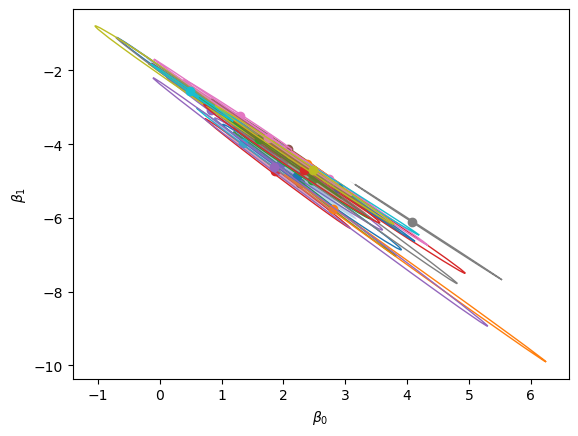

In [38]:
for i in np.arange(num_region):
    p = plt.scatter(ths_eb[i,1], ths_eb[i,2])
    freqepid.confidence_ellipse(
        ths_eb[i,1:], Vs_eb[i,1:,1:], n_std = chi_pa,
        facecolor=p.get_facecolor(), alpha=0.3)
    freqepid.confidence_ellipse(
        ths_mle[i,1:], Vs_mle[i,1:,1:], n_std = chi_pa,
        edgecolor=p.get_facecolor(), facecolor='none', alpha=1)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); #plt.legend(loc=(1.02,0))

## robust CR

In [39]:
rho_pa = np.zeros(num_region)
rho_l = np.zeros(num_region)

In [40]:
for i in np.arange(num_region):
    start_iter = time.time()
    
    rho_pa[i] = result_ebcr.cv.rho(chi_pa, result_ebcr.m2s[i],
                                   result_ebcr.m4s[i]+1e-2)['alpha']
    
    rho_l[i] = result_ebcr.cv.rho_l(chi_pa, result_ebcr.m2s[i],
                                    result_ebcr.m4s[i])['alpha']
    
    print("region %d finished, lapse: %.2f sec."
          %(i, time.time()-start_iter))

region 0 finished, lapse: 0.34 sec.
region 1 finished, lapse: 0.28 sec.
region 2 finished, lapse: 0.44 sec.
region 3 finished, lapse: 0.29 sec.
region 4 finished, lapse: 0.28 sec.
region 5 finished, lapse: 0.28 sec.
region 6 finished, lapse: 0.28 sec.
region 7 finished, lapse: 0.28 sec.
region 8 finished, lapse: 0.45 sec.
region 9 finished, lapse: 0.28 sec.
region 10 finished, lapse: 0.28 sec.
region 11 finished, lapse: 0.28 sec.
region 12 finished, lapse: 0.28 sec.
region 13 finished, lapse: 0.28 sec.
region 14 finished, lapse: 0.28 sec.
region 15 finished, lapse: 0.28 sec.
region 16 finished, lapse: 0.28 sec.
region 17 finished, lapse: 0.40 sec.
region 18 finished, lapse: 0.28 sec.
region 19 finished, lapse: 0.28 sec.
region 20 finished, lapse: 0.28 sec.
region 21 finished, lapse: 0.44 sec.
region 22 finished, lapse: 0.28 sec.
region 23 finished, lapse: 0.28 sec.
region 24 finished, lapse: 0.46 sec.
region 25 finished, lapse: 0.33 sec.
region 26 finished, lapse: 0.29 sec.
region 27 f

In [41]:
rho_pa

array([0.07897128, 0.08274615, 0.12535189, 0.09428088, 0.10448051,
       0.06924934, 0.08637189, 0.10237254, 0.16693622, 0.08702576,
       0.11087474, 0.09405058, 0.08501334, 0.1032479 , 0.08002327,
       0.08696017, 0.09578821, 0.16127165, 0.09859662, 0.10652886,
       0.06709051, 0.11817284, 0.08036409, 0.10506524, 0.19495247,
       0.0745095 , 0.08452079, 0.06073964, 0.08908523, 0.09226495])

In [42]:
rho_l

array([0.0787062 , 0.08204269, 0.12531288, 0.093068  , 0.10342801,
       0.06911249, 0.08601383, 0.10166237, 0.16689487, 0.08651688,
       0.10933013, 0.09347757, 0.0846399 , 0.10172706, 0.0796933 ,
       0.08633584, 0.09433252, 0.16125657, 0.09770739, 0.10441184,
       0.06692923, 0.11814451, 0.0798446 , 0.10408939, 0.19549703,
       0.07414555, 0.08378176, 0.0606348 , 0.08842605, 0.09178489])

In [43]:
chi_eb = np.zeros(num_region)

In [44]:
for i in np.arange(num_region):
    start_iter = time.time()
    
    chi_eb[i] = result_ebcr.chi_eb(i, 0.05, linear=True)
    
    print("region %d finished, lapse: %.2f sec."
          %(i, time.time()-start_iter))

region 0 finished, lapse: 3.21 sec.
region 1 finished, lapse: 2.97 sec.
region 2 finished, lapse: 2.75 sec.
region 3 finished, lapse: 2.74 sec.
region 4 finished, lapse: 2.98 sec.
region 5 finished, lapse: 3.18 sec.
region 6 finished, lapse: 2.78 sec.
region 7 finished, lapse: 3.15 sec.
region 8 finished, lapse: 2.51 sec.
region 9 finished, lapse: 2.93 sec.
region 10 finished, lapse: 2.94 sec.
region 11 finished, lapse: 2.93 sec.
region 12 finished, lapse: 2.78 sec.
region 13 finished, lapse: 2.97 sec.
region 14 finished, lapse: 3.26 sec.
region 15 finished, lapse: 2.95 sec.
region 16 finished, lapse: 2.75 sec.
region 17 finished, lapse: 3.00 sec.
region 18 finished, lapse: 3.15 sec.
region 19 finished, lapse: 2.94 sec.
region 20 finished, lapse: 3.18 sec.
region 21 finished, lapse: 2.97 sec.
region 22 finished, lapse: 3.14 sec.
region 23 finished, lapse: 2.93 sec.
region 24 finished, lapse: 2.78 sec.
region 25 finished, lapse: 2.96 sec.
region 26 finished, lapse: 2.93 sec.
region 27 f

In [45]:
chi_eb

array([2.99664725, 3.02174654, 3.28650901, 3.09189597, 3.14269993,
       2.93826971, 3.04044594, 3.12861294, 3.44925603, 3.04594194,
       3.17618266, 3.0853584 , 3.03273373, 3.14048653, 3.0031895 ,
       3.04657268, 3.10171937, 3.52613584, 3.11235905, 3.15955601,
       2.92248659, 3.27351973, 3.0065154 , 3.1447605 , 3.80715376,
       2.97198858, 3.03269746, 2.87483434, 3.05940265, 3.0750465 ])

In [46]:
rho_eb = np.zeros(num_region)

In [47]:
for i in np.arange(num_region):
    start_iter = time.time()
    
#     rho_eb[i] = result_ebcr.cv.rho(chi_pa, result_ebcr.m2s[i],
#                                    result_ebcr.m4s[i]+1e-2)['alpha']
    
    rho_eb[i] = result_ebcr.cv.rho_l(chi_eb[i], result_ebcr.m2s[i],
                                    result_ebcr.m4s[i])['alpha']
    
    print("region %d finished, lapse: %.2f sec."
          %(i, time.time()-start_iter))

region 0 finished, lapse: 0.23 sec.
region 1 finished, lapse: 0.22 sec.
region 2 finished, lapse: 0.22 sec.
region 3 finished, lapse: 0.22 sec.
region 4 finished, lapse: 0.22 sec.
region 5 finished, lapse: 0.22 sec.
region 6 finished, lapse: 0.22 sec.
region 7 finished, lapse: 0.22 sec.
region 8 finished, lapse: 0.22 sec.
region 9 finished, lapse: 0.22 sec.
region 10 finished, lapse: 0.22 sec.
region 11 finished, lapse: 0.22 sec.
region 12 finished, lapse: 0.22 sec.
region 13 finished, lapse: 0.22 sec.
region 14 finished, lapse: 0.22 sec.
region 15 finished, lapse: 0.22 sec.
region 16 finished, lapse: 0.22 sec.
region 17 finished, lapse: 0.22 sec.
region 18 finished, lapse: 0.22 sec.
region 19 finished, lapse: 0.22 sec.
region 20 finished, lapse: 0.22 sec.
region 21 finished, lapse: 0.22 sec.
region 22 finished, lapse: 0.22 sec.
region 23 finished, lapse: 0.22 sec.
region 24 finished, lapse: 0.22 sec.
region 25 finished, lapse: 0.22 sec.
region 26 finished, lapse: 0.22 sec.
region 27 f

In [48]:
rho_eb

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

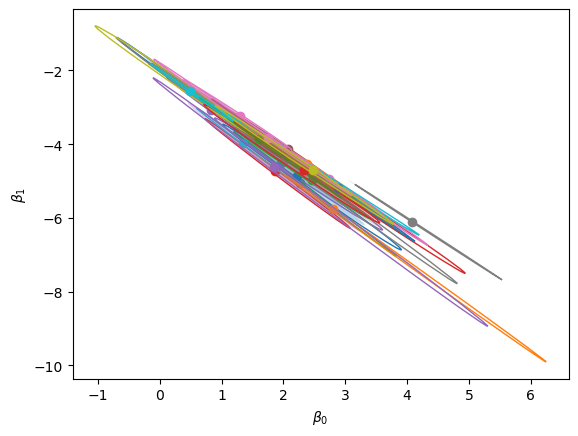

In [49]:
for i in np.arange(num_region):
    p = plt.scatter(ths_eb[i,1], ths_eb[i,2])
    freqepid.confidence_ellipse(
        ths_eb[i,1:], Vs_eb[i,1:,1:], n_std = chi_eb[i],
        facecolor=p.get_facecolor(), alpha=0.3)
    freqepid.confidence_ellipse(
        ths_mle[i,1:], Vs_mle[i,1:,1:], n_std = chi_pa,
        edgecolor=p.get_facecolor(), facecolor='none', alpha=1)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); #plt.legend(loc=(1.02,0))

In [50]:
# plt.figure(figsize=(12,9))

# plt.subplot(1,2,1)
# plt.gca().invert_yaxis()
# for i, r in enumerate(regions):
#     se2 = np.diag(Vs_mle[i])[k+3]
#     if se2 > 0:
#         plt.plot([bs_mle[i,k+1]-chi_pa*np.sqrt(se2), 
#                   bs_mle[i,k+1]+chi_pa*np.sqrt(se2)],
#                  [i, i], color='C%d'%i)
#     else:
#         plt.axhline(y=i, color='C%d'%i)
#     plt.scatter(bs_mle[i,k+1], i, color='C%d'%i)

# plt.axvline(x=0, color='red')
# plt.yticks(np.arange(len(regions)), regions)
# plt.xlim(-20,20)

# plt.subplot(1,2,2)
# plt.gca().invert_yaxis()
# for i, r in enumerate(regions):
#     se2 = np.diag(covs_eb[i])[k+2]
#     if se2 > 0:
#         plt.plot([ths_eb[i,k+2]-chi_eb[i]*np.sqrt(se2), 
#                   ths_eb[i,k+2]+chi_eb[i]*np.sqrt(se2)],
#                  [i, i], color='C%d'%i)
#     else:
#         plt.axhline(y=i, color='C%d'%i)
#     plt.scatter(ths_eb[i,k+2], i, color='C%d'%i)

# plt.axvline(x=0, color='red')
# plt.yticks(np.arange(len(regions)), regions)
# plt.xlim(-20,20)

# plt.show()

In [51]:
# argsort_Y = np.argsort([np.max(Y) for Y in Ys_raw])

In [52]:
# argsort_T = np.argsort([Y.shape[0] for Y in Ys_raw])

In [53]:
# argsort_se = np.argsort([np.diag(Vs_mle[i])[2] for i in np.arange(num_region)])[::-1]

In [39]:
argsort_se = np.arange(num_region)[::-1]

In [57]:
np.savez('result_delphi_ML.npz',
         ns_mle = ns_mle, ms_mle = ms_mle, 
         bs_mle = bs_mle, covs_mle = covs_mle,
         ths_mle = ths_mle, Vs_mle = Vs_mle, chi_pa = chi_pa,
         ths_eb = ths_eb, Vs_eb = Vs_eb, chi_eb = chi_eb)

In [37]:
locals().update(np.load("result_delphi_ML.npz"))

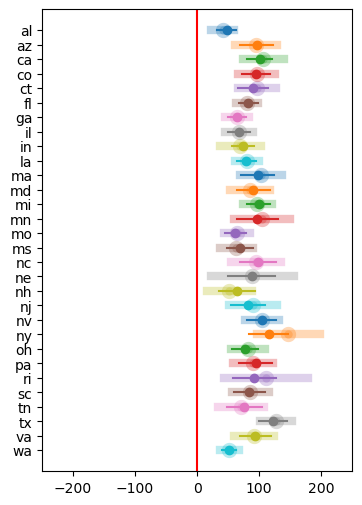

In [40]:
plt.figure(figsize=(4,6))

for j, i in enumerate(argsort_se):
    se2 = np.diag(Vs_mle[i])[2]
    if se2 > 0:
        plt.plot(np.array([ths_mle[i,2]-chi_pa*np.sqrt(se2), 
                  ths_mle[i,2]+chi_pa*np.sqrt(se2)])*(-20),
                 [j, j], color='C%d'%i, alpha=0.3, linewidth=6)
    else:
        plt.axhline(y=j, color='C%d'%i, alpha=0.3, linewidth=6)
    plt.scatter(ths_mle[i,2]*(-20), j, color='C%d'%i, alpha=0.3, linewidth=5)

    se2 = np.diag(Vs_eb[i])[2]
    if se2 > 0:
        plt.plot(np.array([ths_eb[i,2]-chi_eb[i]*np.sqrt(se2), 
                  ths_eb[i,2]+chi_eb[i]*np.sqrt(se2)])*(-20),
                 [j, j], color='C%d'%i)
    else:
        plt.axhline(y=j, color='C%d'%i)
    plt.scatter(ths_eb[i,2]*(-20), j, color='C%d'%i)

plt.axvline(x=0, color='red')
plt.yticks(np.arange(len(regions)), regions[argsort_se])
plt.xlim(-250,250)

plt.show()

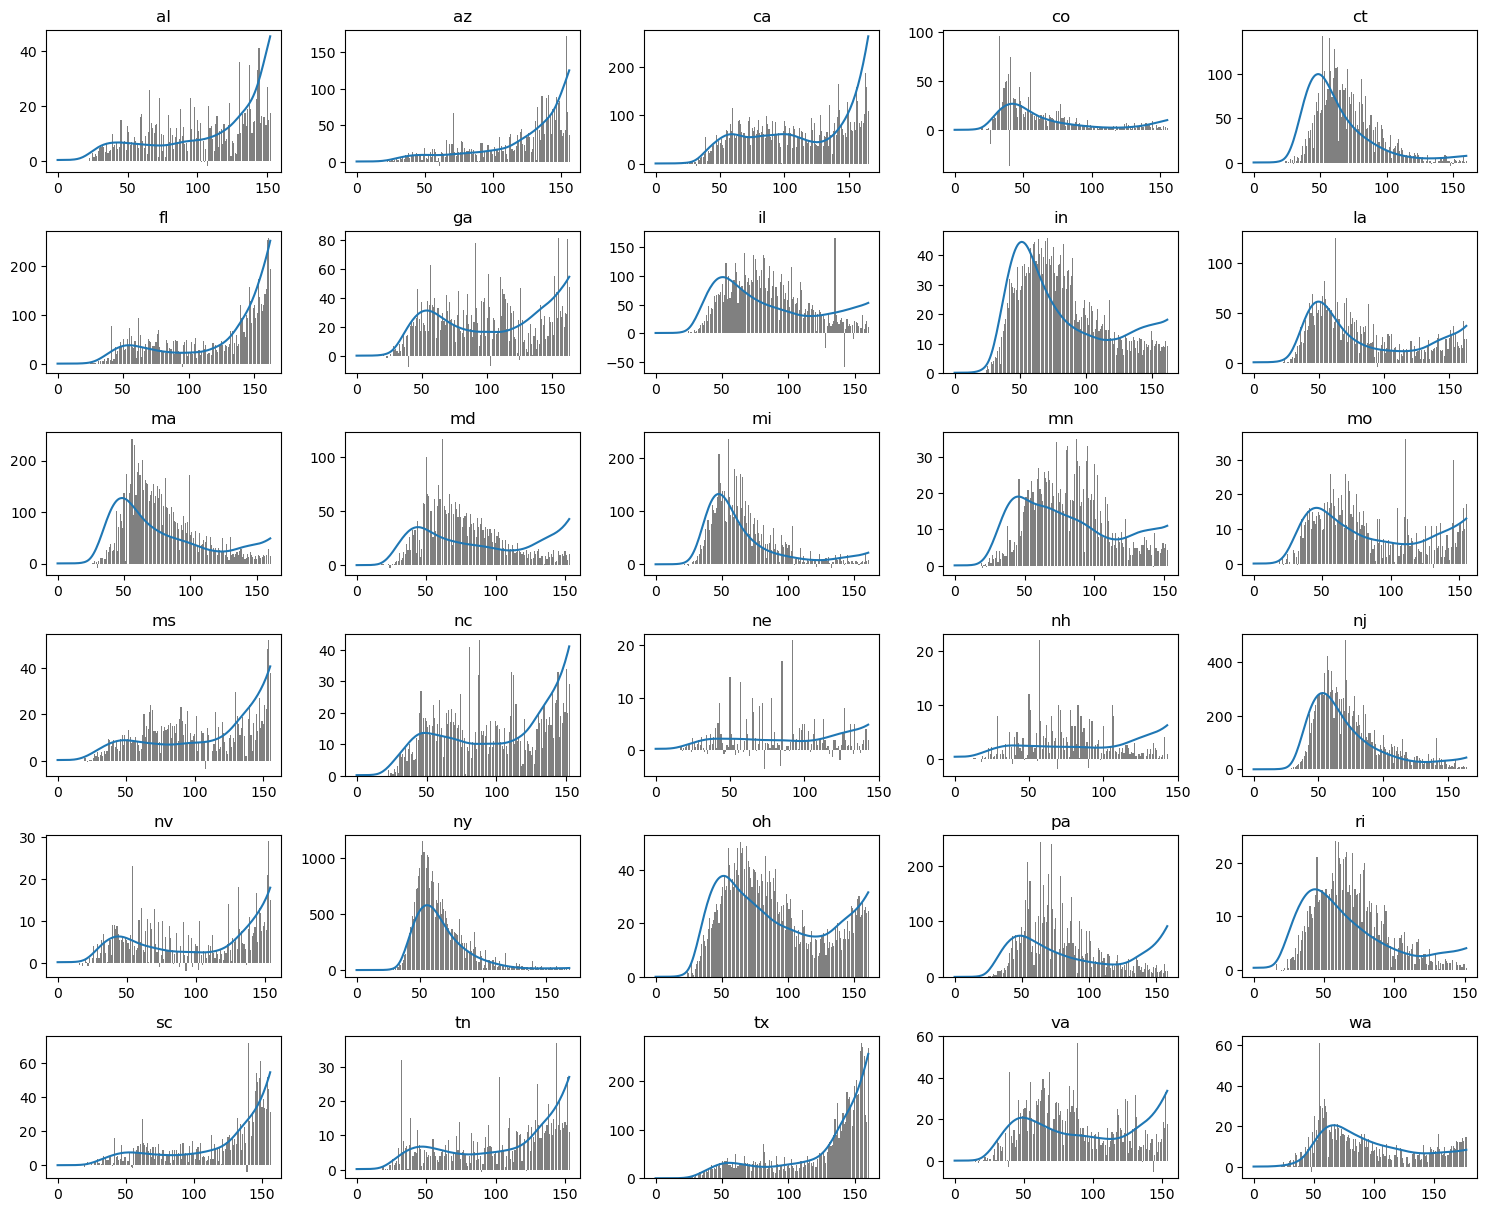

In [41]:
plt.figure(figsize=(15, int(len(regions)/5+1)*2))

for i, r in enumerate(regions):
    plt.subplot(int(len(regions)/5+1),5,i+1)
    
    Y = np.array(data[data.geo_value == r].deaths)
    T = Y.shape[0]
    
    A = np.zeros([T, d])
    A[:,0] = np.full(T, 1)
    A[:,1:] = np.array(data[data.geo_value == r].iloc[:,ivs]) * (-20) + 1.6

    plt.bar(np.arange(T), Y, color='grey')
    plt.plot(model.predict_EY(A, ths_eb[i,0], ths_eb[i,1:]))
    plt.title('%s'%r)
    
plt.tight_layout()